## DATA EXTRACTION

STEP1
- Code to extract and save movie-wise shen-parcellated fMRI data from the Human Connectome Project (HCP)'s social task dataset. The dataset has fMRI data from 1048 subjects.
- Task info: subjects watched 20s animations that were labelled by the experimenters and previous studies as "mental" and "random" - 5 stimuli/condition. Participants were asked to rate stimuli as mental, random or unsure after the end of the animation, 
- Our analysis of the behavioral data showed that although participants' reports in general agreed with the expter-assigned labels this was not always the case
- The fMRI data we obtained from the HCP online repository has been already preprocessed by them (motion corrected, unwarping, spatial normalization to MNI space etc. details in Barch et al, 2013, NI).
- Further, voxel-wise data has already been parcellated into 268 ROIs/nodes spanning the whole brain as per Shen parcellation.
- Here we begin by (1) removing subjects with missing runs, delayed stimulus presentations etc., and then move on to (2) temporally preprocess timecourses (Z-score normalization, trialwise baseline-correction), (3) isolate data from individual trials (t-3 to t+28, where t is the first TR for a single trial/movie, and 28 volumes were acquired in 20s)


TERMS/ABBREVIATIONS USED INTERCHANGEABLY:
- movie <-> trial
- mental <-> social <-> "yes" response/responder
- random <-> non-social <-> "no" response/responder
- nodes <-> regions of interest <-> ROIs
- subjects <-> participants <-> subs

@CODE REVIEWER: COMMENTS TO YOU START WITH "@CODE REVIEWER"

REKHA VARRIER, OCTOBER 2021

### Importing packages and parcellated fMRI data, exploring datatypes etc.

In [20]:
# import packages, check folders
#%reset
from pathlib import Path
from datetime import datetime
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'

print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

fmri_dir = "/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha"
os.chdir(fmri_dir)
print('\nchanged current directory to:\n', fmri_dir)

''' # don't really need these, they're there just to explore data storage
folderName = os.path.join(fmri_dir,'indiv_data') # fMRI data is stored here
print("\nnumber of folders=",len(os.listdir(folderName)))

subj_folders = [i for i in os.listdir(folderName)]
print('subject folders',subj_folders[:10]) #beh data n=1051'''

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code

changed current directory to:
 /Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha


' # don\'t really need these, they\'re there just to explore data storage\nfolderName = os.path.join(fmri_dir,\'indiv_data\') # fMRI data is stored here\nprint("\nnumber of folders=",len(os.listdir(folderName)))\n\nsubj_folders = [i for i in os.listdir(folderName)]\nprint(\'subject folders\',subj_folders[:10]) #beh data n=1051'

In [18]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


<class 'h5py._hl.files.File'>
f_RL.keys()= <KeysViewHDF5 ['shen268_timecourses', 'subjlist']> 

type(d)= <class 'h5py._hl.dataset.Dataset'>
d.shape= (1053, 274, 268)
d.dtype= float64
d= <HDF5 dataset "shen268_timecourses": shape (1053, 274, 268), type "<f8"> 

type(d_RL): <class 'numpy.ndarray'>
d_RL.shape (1053, 274, 268)
d_RL.shape (1053, 274, 268)


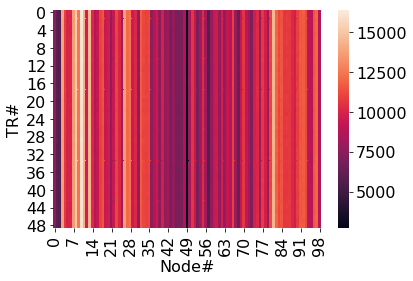

In [14]:
print(os.getcwd()) # current dir
#read in the shen-parcellated (268 ROIs) timecourses for all subjects and all nodes 
f_RL = h5py.File("shen268_timecourses_RL.hdf5", "r") # dims: (subj*timecourseperrun*node), run 1 - first five movies
f_LR = h5py.File("shen268_timecourses_LR.hdf5", "r") # run 2 - next/last 5 movies
f_LR

#playing around with this datatype
print(type(f_RL))
print('f_RL.keys()=',f_RL.keys(), '\n') # h5py.File() acts like a dictionary

# Exploring the datatype
d = f_RL['shen268_timecourses'] # d is of type Dataset. Like NumPy arrays, datasets have a shape() method.
print('type(d)=', type(d))
print('d.shape=',d.shape) # subjects, scan volumes, nodes
print('d.dtype=',d.dtype)
print('d=',d, "\n")

d_RL = np.array(f_RL['shen268_timecourses']) # extracting timecourses and converting them to arrays
print('type(d_RL):',type(d_RL))
print('d_RL.shape',d_RL.shape)


sns.heatmap(d_RL[0,1:50,1:100]) # plot a few timepts and nodes of subject 0 to get an idea
plt.xlabel("Node#")
plt.ylabel("TR#")
print('d_RL.shape',d_RL.shape)

From the plot above, it looks like timecourses are more similar across time within a node than across nodes - make sense - it could reflect firing props of neurons within that node or anything else typical of an roi

Now let's get working on the dataset. First we extract the data per run

## Extracting timecourses, subject indices

In [21]:
#extract fMRI data and subject names
dat = {}
dat["run1"] = np.array(f_RL['shen268_timecourses'])
dat["run2"] = np.array(f_LR['shen268_timecourses'])
print('type(dat):',type(dat))

# subject list
subj_list = {}
subj_list["run1"] = [x.decode('utf8') for x in list(f_RL['subjlist'])] #RL--> order of subjects for run 1
subj_list["run2"] = [x.decode('utf8') for x in list(f_LR['subjlist'])] #LR
# Python string method decode() decodes the string using the codec registered for encoding.
# It defaults to the default string encoding.
print('type(subj_list):',type(subj_list))


type(dat): <class 'dict'>
type(subj_list): <class 'dict'>


In [24]:
# movies were presented in two runs, in the same order and at the same onset times (i.e., no jitter added)

vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]#RL
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]#LR

vid_cat = {} # video category (mental/random or social/nonsocial)
vid_cat["run1"] = [1,0,0,1,0] # 1:mental,0: random
vid_cat["run2"] = [1,1,0,1,0]

## Info needed to isolate stimulus presentation windows


In [26]:
vid_onsets_in_sec = [8, 46, 84, 122, 160] # from analysis by EF

## Verifying some things we know about the behavioral data

### @ CODE REVIEWER: FEEL FREE TO SKIP THIS SECTION. THIS PART ONLY VERIFIES THE STIMULUS ONSET TIMES LISTED ABOVE

- This was already done by EF, double-checking the onset times mentioned above, and also that there is no jitter in stim onset times
- all videos were 20 secs long, TR = .7s


nr of files 2087
0 105620_3T_SOCIAL_run1_TAB.txt
actual: 10.089 mean: 8


<AxesSubplot:>

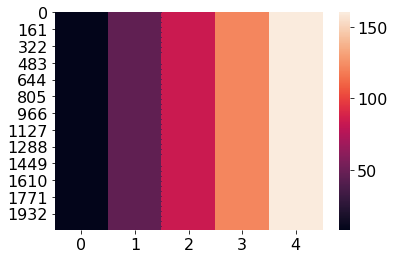

In [9]:
# extracting in-scanner behavioral data


txt_files_loc = os.path.join(fmri_dir,'inscanner_behav_data')
files = os.listdir(txt_files_loc)
print('nr of files',len(files))
onset_times = np.empty((len(files),5))
onset_times[:] = np.nan
for i,f in enumerate(files):
    #print(f)
    indiv_beh_dat = pd.read_csv(os.path.join(txt_files_loc,f),delimiter='\t')
    baseline = indiv_beh_dat['CountDownSlide.OnsetTime'].values[0]
    o =  indiv_beh_dat['MovieSlide.OnsetTime'].values
    onset_times[i,:] = o[~np.isnan(o)]
    onset_times[i,:] = onset_times[i,:] - baseline
    onset_times[i,:] = onset_times[i,:]/1000
    
    for vid_no in range(5):
        if onset_times[i,vid_no] - vid_onsets_in_sec[vid_no] > .5: # sub and movie deviating from group mean
            print(vid_no,f)
            print('actual:',onset_times[i,vid_no],'mean:',vid_onsets_in_sec[vid_no])
sns.heatmap(onset_times)

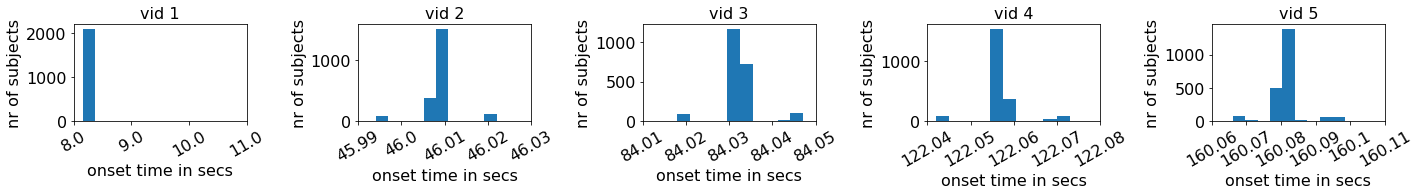

In [12]:
# verifying onset times across subjects
plt.figure(1,figsize = (20,3))

for vid_no in range(5):
    plt.subplot(1,5,vid_no+1)
    plt.title(f'vid {vid_no+1}')
    plt.hist(onset_times[~np.isnan(onset_times[:,vid_no]),vid_no])
    ticks = plt.xticks()
    ticks = ticks[0]
    plt.xticks(ticks,[np.round(t,2) for t in ticks],rotation =30)
    plt.xlabel ('onset time in secs')
    plt.ylabel("nr of subjects")
plt.tight_layout()



- all except one subject has the same mean as the group - i.e., no jitter overall

- For the subject with the delay (105620, run 1), the stimulus coaxing was only presented for 18s, and presentation onset was 2sec later than the others. Let's exclude this individual from the analyses

- also, 8.25 is a more accurate onset TR for stim 0 in both runs

@CODE REVIEWER: PLEASE CONTINUE FROM HERE.

## Converting onset times to TRs

In [30]:
vid_onsets_in_sec = [8.25, 46, 84, 122, 160]
 # actual time in secs

#exploring the timecourse
print('time between onsets=',np.diff(vid_onsets_in_sec))
task_duration_secs = 20 # stimulus presentation duration
RW_secs = 3
fix_window_secs = np.diff(vid_onsets_in_sec)[0] - (task_duration_secs+RW_secs)
print('task:',task_duration_secs,'\nRW:',RW_secs,'\nfixation:',fix_window_secs,'secs')


time between onsets= [37.75 38.   38.   38.  ]
task: 20 
RW: 3 
fixation: 14.75 secs


In [37]:
#converting onset times to TRs
tr = 0.72
vid_onsets_imagenr = np.zeros_like(vid_onsets_in_sec)
for i in range(5):
    #vid_onsets_imagenr[i] = np.floor((vid_onsets_in_sec[i]/tr)-1) # safer to subtract one, but in our study, we'd start too early then
    vid_onsets_imagenr[i] = np.floor((vid_onsets_in_sec[i]/tr)) # seconds to image nr 

print('video onsets in TRs:',vid_onsets_imagenr)


video onsets in TRs: [ 11.  63. 116. 169. 222.]


### Is the conversion to TR okay?m
- done by converting onset TRs back into seconds to see how close it is to the original TRs

In [15]:
(vid_onsets_imagenr)*tr

array([  7.92,  45.36,  83.52, 121.68, 159.84])

In [35]:
(vid_onsets_imagenr-1)*tr # alternate algorithm, going back one additional image. 
#this is less precise (further from vid_onsets_in_sec) than the previous conversion qn

array([  7.2 ,  44.64,  82.8 , 120.96, 159.12])

In [38]:
print('nr. of TRs between onsets:',np.diff(vid_onsets_imagenr)) # sanity check: are the distances between onset images the same?

l_task = int(np.round(task_duration_secs/tr))  # duration measured in nr of images = 28 for 20s
print('Duration of task block:', l_task)


nr. of TRs between onsets: [52. 53. 53. 53.]
Duration of task block: 28


## Visualizing a run

vertical lines show 5 TRs before and 5 after the onset time for each video


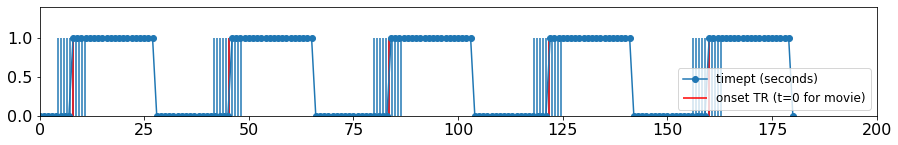

In [43]:
x = np.zeros((181,))
for i in range(len(vid_onsets_in_sec)):
    x[int(vid_onsets_in_sec[i]):int(vid_onsets_in_sec[i])+20] = 1
plt.figure(1,figsize = (15,2))
plt.plot(x,marker = 'o', label = 'timept (seconds)')
x_ims = [tr*i for i in range(int(np.ceil(181/tr)))]
x_ims
for i in vid_onsets_imagenr:
    i = int(i)
    plt.vlines(x_ims[i-5:i+5],-1,1) # vertical lines 5 TRs before and after
plt.vlines(vid_onsets_imagenr*tr,-1,1,color = 'r', label = 'onset TR (t=0 for movie)')
#plt.vlines(vid_onsets_imagenr*tr-1,-1,1,color = 'magenta', label = 'onset TR-1')

#for i in range(len(x_ims)):
#    plt.text(x_ims[i],1.1,i,rotation=90)
plt.ylim(0,1.4)
plt.xlim(0,200)
plt.legend(loc = 'lower right',fontsize = 12)

Red is the correct one, magenta should be used only if the video has t=0 at the timept before the first t=1


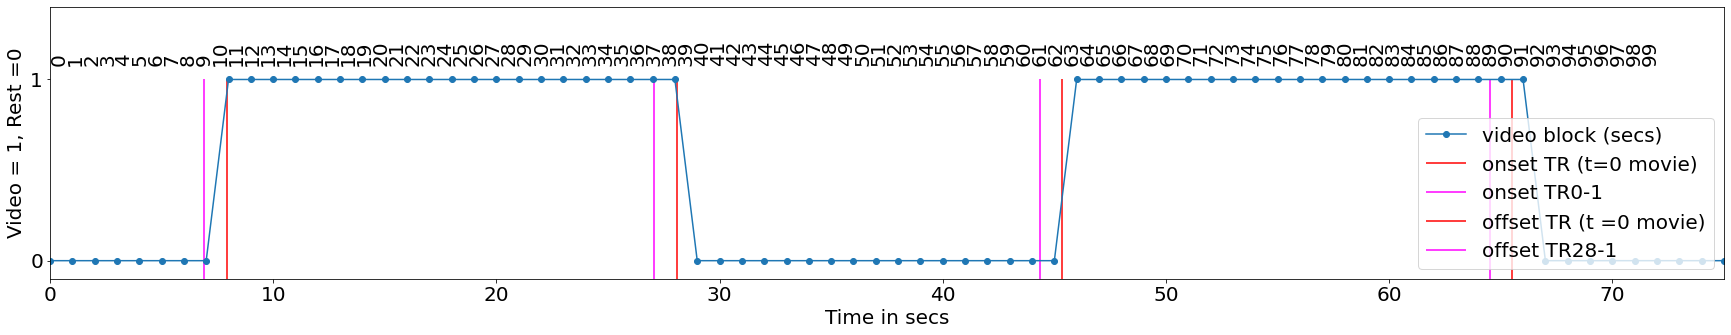

In [45]:
# another visualization (purpose of these was to ascertain that the t=0 point is the correct onset point)
# for one-on-one meeting on 17.08.21
x = np.zeros((181,))
for i in range(len(vid_onsets_in_sec)):
    x[int(vid_onsets_in_sec[i]):int(vid_onsets_in_sec[i])+21] = 1 # time 0 to time 20 is 21 points. 
    #but start counting only from the first "1" timept - call it TR=0 (not 1)
plt.figure(1,figsize = (30,5))
plt.plot(x,marker = 'o', label = 'video block (secs)')
x_ims = [tr*i for i in range(int(np.ceil(181/tr)))]
x_ims
#for i in vid_onsets_imagenr:
#    plt.vlines(x_ims[i-5:i+5],-1,1)
plt.vlines(vid_onsets_imagenr*tr       ,-1,1,color = 'r',       label = 'onset TR (t=0 movie)')
plt.vlines((vid_onsets_imagenr)*tr-1   ,-1,1,color = 'magenta', label = 'onset TR0-1')
plt.vlines((vid_onsets_imagenr+28)*tr,-1,1,color = 'r',       label = 'offset TR (t =0 movie)')
plt.vlines((vid_onsets_imagenr+28)*tr-1  ,-1,1,color = 'magenta', label = 'offset TR28-1')
print('Red is the correct one, magenta should be used only if the video has t=0 at the timept before the first t=1')
plt.xticks(fontsize =20)
plt.yticks([0,1],fontsize =20)
for i in range(len(x_ims[:100])):
    plt.text(x_ims[i],1.1,i,rotation=90,fontsize = 20)
plt.ylim(-.1,1.4)
plt.xlim(0,75)
plt.xlabel('Time in secs',fontsize =20)
plt.ylabel('Video = 1, Rest =0',fontsize =20)
plt.legend(fontsize =20, loc = 'lower right')

## Extract TRs for each movie

- store a list of TRs relevant for each movie - starting from onset TR-3 to the end of the video 

In [46]:
# specify whether to include pre-/post-stim fixation TRs

l_task = int(np.round(task_duration_secs/tr))  # duration of video measured in #TRs = 28 for 20s

include_post_task_fixation = False # change to 1 to include 15 TRs after task or -1 to include
include_pre_task_fixation = True

# 3 baseline TRs
if (include_post_task_fixation == True) and (include_pre_task_fixation== False): 
    #preproc used Jan-June

    #l = 34 # duration
    print('Duration of task block:', l_task)

    fix_duration_secs = 15
    print('Nr of fixation images:', np.round(fix_duration_secs/tr))

    l_fix_start = 0 # nr of fixation pts before the start
    l_fix_end = int(l_task/2)
    
    l_resp_screen = int(np.round(3/tr))
    print("Duration of resp screen:", l_resp_screen)

elif (include_post_task_fixation == False) and (include_pre_task_fixation== True):
    # for later preprocessing - from June
    
    l_fix_start = 3 # 3 pre-task TRs
    l_fix_end = 0
    
# check if TRs are correct
print('TRs before vid: l_fix_start=',l_fix_start,'\nTRs after vid: l_fix_end=',l_fix_end)
print('l_task:',l_task)


TRs before vid: l_fix_start= 3 
TRs after vid: l_fix_end= 0
l_task: 28


In [48]:
n_init_TRs_to_delete = 5 # first few TRs  of each run will be deleted since they are scanner noise


In [49]:
# Store moviewise time windows

nmovies = 10
timepts_indiv_movie = [] # to store timepts (prestim fix if applicable + stim + poststim fix) for each movie

for vid_no in range(nmovies):
    run = "run1" if vid_no < 5 else "run2"
    vrun = vid_no%5
    vid = vid_names[run][vrun]
    #print(vid)
    
    start_frame = int(vid_onsets_imagenr[vrun]) - l_fix_start
    end_frame = int(vid_onsets_imagenr[vrun]) + l_task + l_fix_end
    
    timepts = np.arange(start_frame, end_frame+1) # "+1" to include last (the 28th) timept too -
    timepts -= n_init_TRs_to_delete
    # overall 29 timepts
    # in. 0-28 (including both edges)
    timepts_indiv_movie.append(timepts)  # timepts (prestim fix + stim) for each movie

np.save(os.path.join(data_file_loc,'Video_TRs.npy'),timepts_indiv_movie)
timepts_indiv_movie[0].shape# 3 prestim, images start to start+28 (incl edges, so 29)

(32,)

In [50]:
print('nr of timepts per movie:',[timepts_indiv_movie[i].shape for i in range(10)])
timepts_indiv_movie # list of 10, each item consists of TRs relevant to that movie within its run.
# for analyses post June: t0-3 to t0+28


nr of timepts per movie: [(32,), (32,), (32,), (32,), (32,), (32,), (32,), (32,), (32,), (32,)]


[array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]),
 array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139]),
 array([161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192]),
 array([214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
        227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
        240, 241, 242, 243, 244, 245]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]),
 arr

In [22]:
os.chdir(data_file_loc)
os.getcwd()

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

## Trying to understand the difference between various normalization choices

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes u

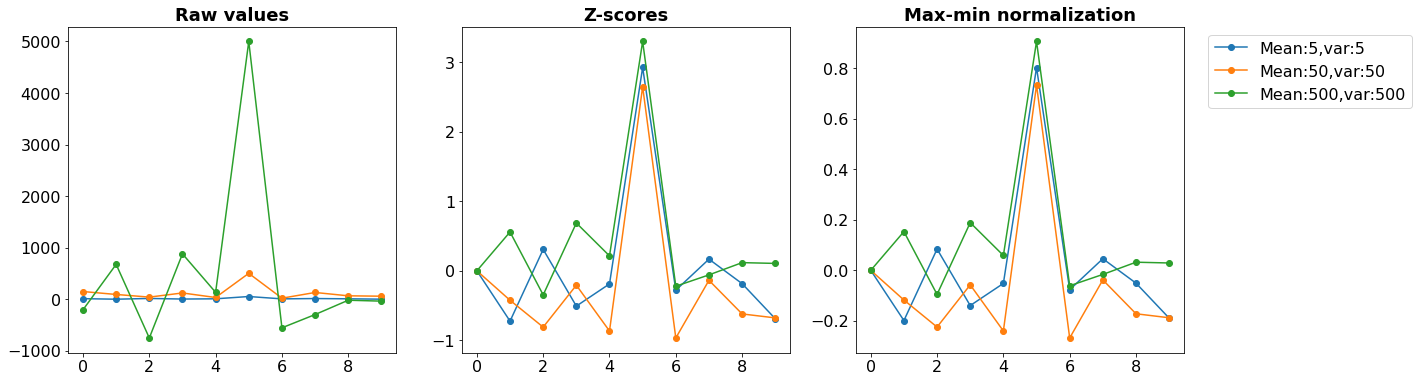

In [51]:
# Exploring normalization options 1: Max min normalization vs. Z-scoring

plt.figure(1,figsize = (20,6))
for i in [5,50, 500]:
    mu = i
    var = i
    x = np.random.normal(loc = mu, scale = var, size =10)
    x[5] = i*10
    plt.subplot(1,3,1)
    plt.plot(x, label = f'raw value,\nmean:{mu},var:{var}', marker = 'o')
    plt.title('Raw values',fontsize = 18, fontweight ='bold')
    #plt.legend(loc = 'upper left')

    plt.subplot(1,3,2)
    x1 = stats.zscore(x)
    x1 = x1 - x1[0]
    plt.plot(x1, label = f'zscore,\nmean:{mu},var:{var}', marker = 'o')
    plt.title('Z-scores',fontsize = 18, fontweight ='bold')
    #plt.legend(loc = 'upper left')
    
    x2 = x - min(x)
    x2 = x2/max(x2)
    x2 = x2 - x2[0]
    plt.subplot(1,3,3)
    plt.plot(x2,label =f'Mean:{mu},var:{var}', marker = 'o')
    plt.title('Max-min normalization',fontsize = 18, fontweight ='bold')
     
    plt.legend(bbox_to_anchor=(1.05, 1),fontsize = 16)

- no big difference between maxmin-normalizatin and Z-score normalization, but will stick to Z-score and follow it up with baseline correction.
- Two types of normalizations will be done and data stored separately:
    - type 1: runwise normalization followed by baseline correction wrt the average of the first 3 timepts (-3,-2,-1)
    - type 2: within-trial normalization followed by baseline correction wrt the t=0 timept (i.e., index 3).

- Type 1 is for yes/no comparisons within movie, type 2 is for comparsions across movies (there could be more baseline diffs and activity changes due to the order of movie presentation etc.)



- Before that, let's also extract the behavioral data and remove impossibly short RTs (indicative of accidental button presses etc.)

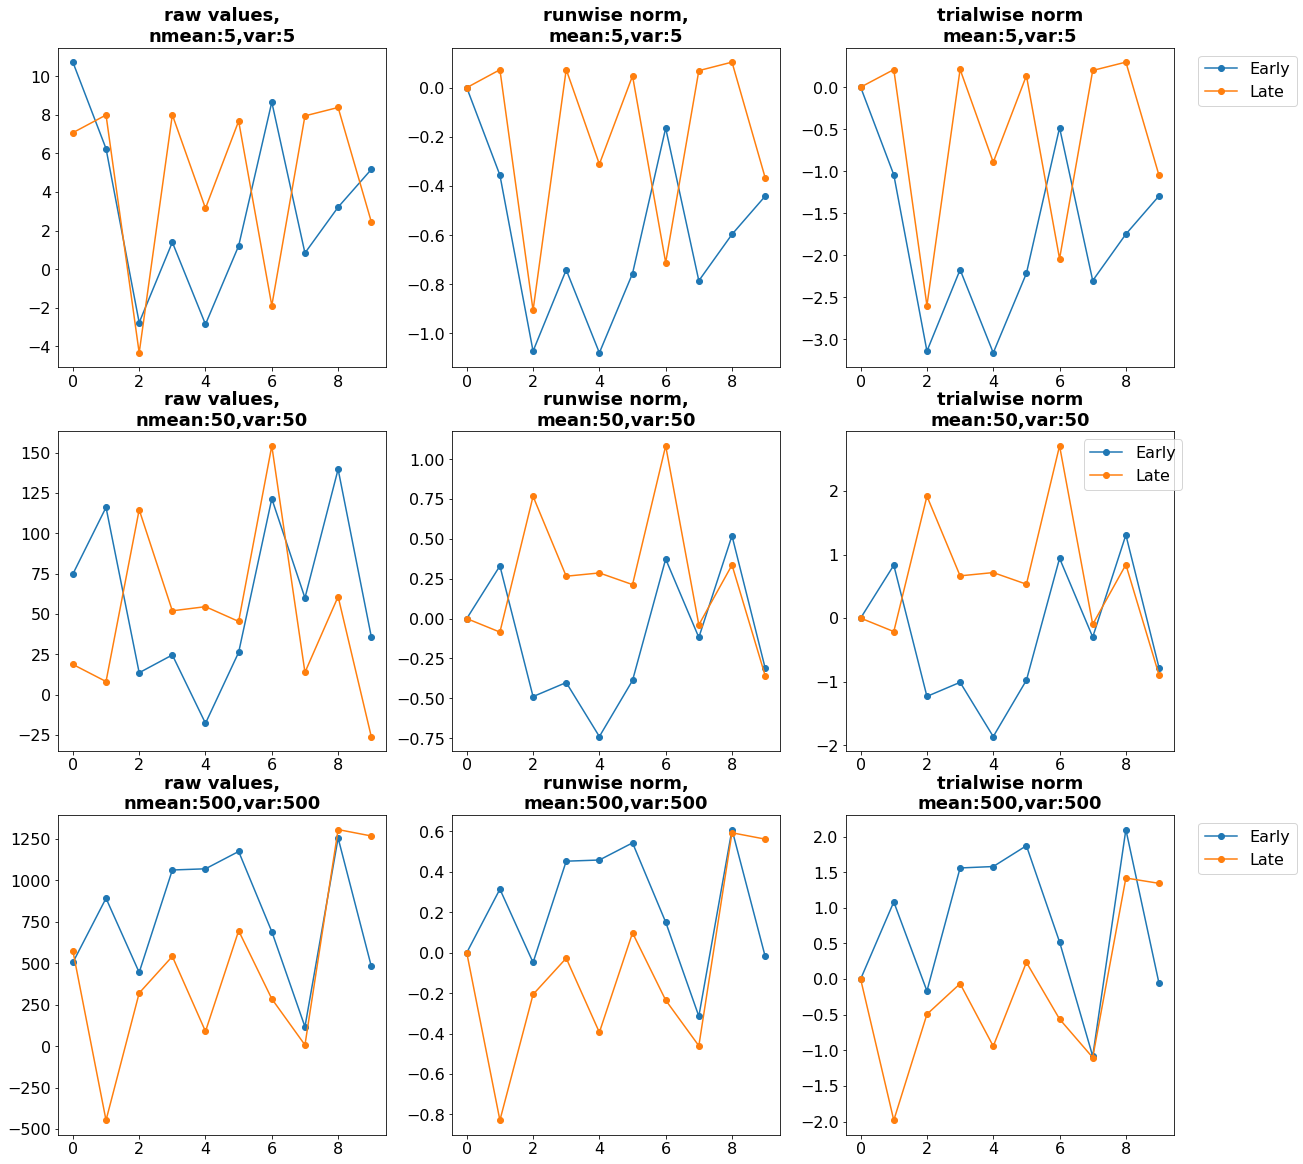

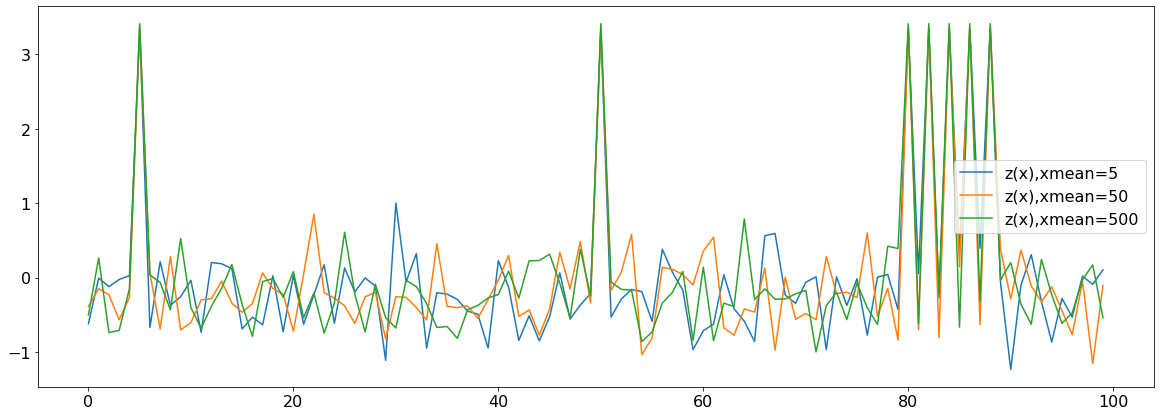

In [84]:
# Exploring normalization options 2: runwise vs. trialwise norm

inds1 = np.array([int(i) for i in np.arange(40,50)])
inds2 = np.array([int(i) for i in np.arange(70,80)])
plt.figure(1,figsize = (20,20))
for iind,i in enumerate([5,50, 500]):
    plt.figure(1)
    mu = i
    var = i
    x = np.random.normal(loc = mu, scale = var, size =100)
    x[[5,50,80,82,84,86,88]] = i*10
    # plot x[40:50] 
    plt.subplot(3,3,iind*3+1)
    plt.plot(x[inds1], label = 'Early', marker = 'o')
    plt.title(f'raw values,\nnmean:{mu},var:{var}',fontsize = 18, fontweight ='bold')
    #plt.legend(loc = 'upper left')

    plt.plot(x[inds2], label = 'Late', marker = 'o')
    #plt.legend(loc = 'upper left')


    #runwise norm (assuming 40:50 is a trial)
    x1 = stats.zscore(x)

    plt.subplot(3,3,iind*3+2)
    x11 = x1[inds1]
    x11 = x11 - x11[0]
    plt.plot(x11, label = 'Early', marker = 'o')
    plt.title(f'runwise norm,\nmean:{mu},var:{var}',fontsize = 18, fontweight ='bold')
    #plt.legend(loc = 'upper left')

    x11 = x1[inds2]
    x11 = x11 - x11[0]
    plt.plot(x11, label = 'Late', marker = 'o')
    #plt.legend(loc = 'upper left')


    # plot x[40:50] trialwise norm (assuming 40:50 is a trial)
    x2 = x[inds1]
    x2 = stats.zscore(x2)
    x2 = x2 - x2[0]

    plt.subplot(3,3,iind*3+3)
    plt.plot(x2,label ='Early', marker = 'o')
    plt.title(f'trialwise norm\nmean:{mu},var:{var}',fontsize = 18, fontweight ='bold')

    x2 = x[inds2]
    x2 = stats.zscore(x2)
    x2 = x2 - x2[0]
    plt.plot(x2,label = 'Late', marker = 'o')
    
    plt.legend(bbox_to_anchor=(1.05, 1),fontsize = 16)
    
    plt.figure(2,figsize =(20,7))
    #plt.plot(x, label = 'x')
    plt.plot(x1, label = f'z(x),xmean={mu}')
    plt.legend()

- as expected, runwise normalization retains magnitude diffs between conditions better than trialwise norm

In [53]:
#extract behavioral data, remove impossibly quick responses RT < 100ms
# approx 10 responses per subject, hence number of rows ~=10k

beh_data = pd.read_csv("/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha/hcp_social_behav_for_ddm_stim-coding.csv")
rtmin = 0.1 # threshold for impossibly short RTs

print('nrows before=', beh_data.shape)
print("total subjects before=",len(np.unique(beh_data['subj_idx'])))

beh_data_old = beh_data
beh_data= beh_data[beh_data["rt"]>=rtmin] # remove trials with RT<.1
print('\nnrows after=', beh_data.shape)
print("total subjects after=",len(np.unique(beh_data['subj_idx'])))
#print(np.where(beh_data.index == subj_shortRT[0]))

nrows before= (10149, 5)
total subjects before= 1051

nrows after= (9950, 5)
total subjects after= 1050


## Subject-wise preprocessing:
- finally coming to the main step
- Extraction of relevant TRs for each subject, normalizing and baseline-correcting it and store in a 4D array
- code below for both with run-wise norm. and trial-wise norm. (for different analyses later)

@CODE REVIEWER: FROM HERE ON, I'D LIKE YOU TO PLEASE VERIFY THAT THERE ARE NO ERRORS

In [55]:
# setting common variables for both types of preprocessing 

nsubj = 1053 #1053 # total 1053, but only 1048 will be in the final data
nmovies = 10#10
nnodes = 268 #268
ntimepts  = len(timepts_indiv_movie[vid_no]) #32
tr0_ind = 3 # timept at which t=0 for video


In [57]:
all_runs_z = np.empty((nsubj,268,274-n_init_TRs_to_delete,2))
all_runs_z[:] = np.nan
#all_runs_maxmin = np.empty_like(all_runs_z) # for maxmin normalization
#all_runs_maxmin[:] = np.nan


subj: 0 , time elapsed: 0.0 mins


<ipython-input-27-8dfe96e13eed>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)


subj: 50 , time elapsed: 0.37 mins
subj: 100 , time elapsed: 0.72 mins
subj: 150 , time elapsed: 1.01 mins
subj: 200 , time elapsed: 1.31 mins
subj: 250 , time elapsed: 1.58 mins
subj: 300 , time elapsed: 1.87 mins
subj: 350 , time elapsed: 2.16 mins
subj: 400 , time elapsed: 2.47 mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj: 450 , time elapsed: 2.74 mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj: 500 , time elapsed: 3.03 mins
subj: 550 , time elapsed: 3.33 mins
subj: 600 , time elapsed: 3.62 mins
subj: 650 , time elapsed: 3.9 mins
subj: 700 , time elapsed: 4.19 mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj: 750 , time elapsed: 4.45 mins
subj: 800 , time elapsed: 4.74 mins
subj: 850 , time elapsed: 5.13 mins
subj: 900 , time elapsed: 5.45 mins
subj: 950 , time elapsed: 5.76 mins
subj: 1000 , time elapsed: 6.08 mins
subj: 1050 , time elapsed: 6.4 mins


Data saved 

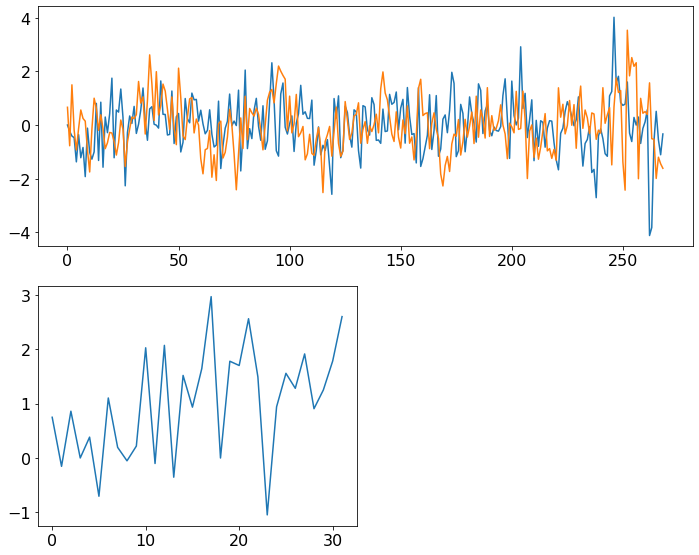

In [27]:
# 1. RUN-wise normalisation (Zscore) and then baseline correction wrt the means of t = -3 to -1.

# this is more useful when comparing responses for the same movie. Within-trial comparison is 
#m more useful for across-movie comparisons

from scipy.signal import detrend

start = time.time()
runSlope = np.empty((nsubj,nnodes,2))

responses = np.empty((nsubj, nmovies))
responses[:] = np.nan # initialise responses with NaN
sub_id_all = []
Ynorm = np.zeros((nsubj, nnodes, ntimepts, nmovies))
plot_fig = 1
if plot_fig:
    plt.figure(1,figsize=(10,8))
sub_ind = -1
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print('subj:',s1,', time elapsed:', np.round((now - start)/60,2),'mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620': # this subject had a delayed stimulus presentation (removing for ease atm)
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                vidName = vid_names[run][vid_no%5]
                vidName = '.'.join((vidName,'AVI')) # add .avi

                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                    responses[sub_ind,vid_no] = beh_data.loc[row,'response']
                if len(np.where(row)[0]) > 1:
                    print('error!!!!')

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # remove first 5 TRs, so 274-5 TRs/run
                tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 
                
                runSlope[sub_ind,node,0] = np.polyfit(np.arange(tc_run1.shape[0]),tc_run1,1)[0]
                # linearly fir the run, and save the slope for the run
                runSlope[sub_ind,node,1] = np.polyfit(np.arange(tc_run2.shape[0]),tc_run2,1)[0]

                tc_run1 = detrend(tc_run1) # removing linear trends
                tc_run2 = detrend(tc_run2)
                tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
                tc_run2 = stats.zscore(tc_run2)
                #tc_run1 = (tc_run1 - np.nanmean(tc_run1))/np.nanstd(tc_run1)
                #tc_run2 = (tc_run2 - np.nanmean(tc_run2))/np.nanstd(tc_run2)
                # why not just exclude the first 5 points? because this way
                # can retain the same indices, ut data unaffected by initial random 
                # values which may skew zscores

                # to plot whole runs later
                if sub_ind < 100:
                    all_runs_z[sub_ind,node,:,0] = tc_run1
                    all_runs_z[sub_ind,node,:,1] = tc_run2

                # baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 

                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    if plot_fig:
                        if node == 0:
                            if (vid_no in [0,5]) and (sub_ind == 0) and (node==0):
                                #print(np.nanmean(Y[0:2]))
                                #print(Y)
                                plt.subplot(2,1,1)
                                plt.plot(tc_run1 if run == 'run1' else tc_run2) # plot a run for a single subject
                            #plt.subplot(2,5,vid_no+1)
                            #plt.plot(Y, marker ='o')

                    #Y = Y-np.nanmean(Y[0:tr0_ind]) #baseline correct using the mean of the 3 TRs prior to stimulus onset
                    Y = Y-Y[tr0_ind] #baseline correct using the mean of the 3 TRs prior to stimulus onset
                    Ynorm[sub_ind,node,:,vid_no] = Y # assign to a 4D array
                    if (vid_no == 0) and (sub_ind == 0) and (node==0): # plot the first tc to illustrate
                        plt.subplot(2,2,3)
                        plt.plot(Ynorm[sub_ind,node,:,vid_no])


        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows
responses = responses[:sub_ind+1,:]
runSlope = runSlope[:sub_ind+1,:,:]
if plot_fig:
    plt.tight_layout()
    
if nsubj == 1053:
    np.save(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm'), Ynorm) # save timecourses
    np.save(os.path.join(data_file_loc,'responses.npy'), responses) # save beh responses

print('\n\nData saved on/at:',datetime.now()) # cell run at



In [19]:
# is data extraction correct?
r = np.load(data_file_loc+'/responses.npy')

## Is there a linear trend?
- this step was done when the above code did not contain a detrending step.
- don't need to run it now that the data has already been detrended

Ttest_1sampResult(statistic=-49.98950663403359, pvalue=0.0)
nr. of nodes with a slope sig different from 0 in run 1:
210
nr. of nodes with a slope sig different from 0 in run 2
228
Slope run 1: mean: -0.03899181115291593 Ttest_1sampResult(statistic=-49.98950663403359, pvalue=0.0)
Slope run 2: mean: -0.07717801757289106 Ttest_1sampResult(statistic=-95.89548049424342, pvalue=0.0)


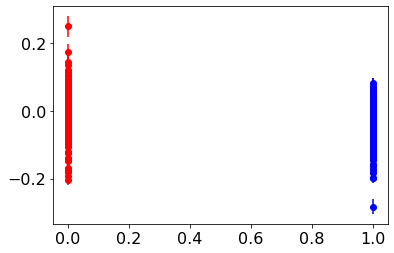

In [28]:
# no need to run this now

plt.figure(1)
plt.errorbar(np.zeros((268,)),np.nanmedian(runSlope[:,:,0],axis=0),stats.sem(runSlope[:,:,0],axis=0),
             marker ='o',color = 'r',ls = 'None')
plt.errorbar(np.ones((268,)),np.nanmedian(runSlope[:,:,1],axis=0),stats.sem(runSlope[:,:,1],axis=0),
             marker ='o',color = 'b',ls = 'None')
print(stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,0]),0))

print('nr. of nodes with a slope sig different from 0 in run 1:')
print(sum([1 if stats.ttest_1samp(runSlope[:,n,0],0)[1]<.05 else 0 for n in range(268)]))

print('nr. of nodes with a slope sig different from 0 in run 2')    
print(sum([1 if stats.ttest_1samp(runSlope[:,n,1],0)[1]<.05 else 0 for n in range(268)]))


print('Slope run 1: mean:',np.nanmean(np.ndarray.flatten(runSlope[:,:,0])),stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,0]),0))
print('Slope run 2: mean:',np.nanmean(np.ndarray.flatten(runSlope[:,:,1])),stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,1]),0))

# example detrending
plt.figure(2)
from scipy.signal import detrend
x = dat['run1'][0,n_init_TRs_to_delete:,0]
plt.figure(1, figsize = (25,5))
plt.plot(x)
plt.plot(detrend(x,type= 'linear'))

- Looks like the slope in all nodes is sig < zero, although the magnitude is very small. So we should detrend before normalizing etc.
- ^^**this has been done already**

In [ ]:
# this code snippet helped determine that the first 5 TRs of a run need to be removed. 
# # this has been done already, so can be run as a sanity check, but is optional
# first 5 TRs of the run

plt.figure(1,figsize =(15,10))
for run in range(2):
    plt.subplot(2,1,run+1)
    plt.title(f'Run{run+1}',fontsize =24)
    for n in np.arange(0,268):
        plt.errorbar(range(10), np.nanmedian(all_runs_z[:,n,:10,run],axis=0),
                     stats.sem(all_runs_z[:,n,:10,run],axis=0,nan_policy='omit'))
                     #color = 'k',alpha = .1)
    ymin,ymax = plt.ylim()
    for i in range(5):
        plt.axvspan(vid_onsets_imagenr[i],vid_onsets_imagenr[i]+28, color = 'red', alpha = .1, label = 'stim')  #vertical shading

    plt.xlim(0,10)
plt.tight_layout()



## Trial-wise normalization

subj: 0 , time elapsed: 0.0 mins
subj: 50 , time elapsed: 0.91 mins
subj: 100 , time elapsed: 1.75 mins
subj: 150 , time elapsed: 2.55 mins
subj: 200 , time elapsed: 3.36 mins
subj: 250 , time elapsed: 4.12 mins
subj: 300 , time elapsed: 4.93 mins
subj: 350 , time elapsed: 5.71 mins
subj: 400 , time elapsed: 6.45 mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj: 450 , time elapsed: 7.18 mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj: 500 , time elapsed: 7.91 mins
['only one subject for ind ', 521, ', subjID:', 286650]
subj: 550 , time elapsed: 8.73 mins
subj: 600 , time elapsed: 9.69 mins
subj: 650 , time elapsed: 10.46 mins
subj: 700 , time elapsed: 11.36 mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj: 750 , time elapsed: 11.98 mins
subj: 800 , time elapsed: 12.78 mins
subj: 850 , time elapsed: 13.48 mins
subj: 900 , time elapsed: 14.17 mins
subj: 950 , time elapsed: 

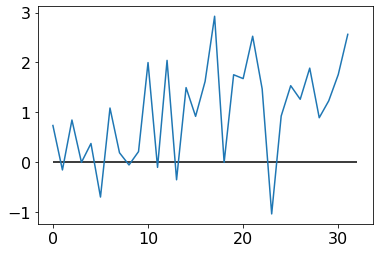

In [156]:
# TRIAL-WISE: subjectwise normalisation(Zscore) within a TRIAL, and then baseline correction wrt t=0 
# (i.e., TR=3).

start = time.time()

#y0 = np.zeros((nsubj,nmovies,nnodes))
Ynorm = np.zeros((nsubj, nnodes, ntimepts,nmovies))

sub_ind = -1
for s1 in np.arange(0,nsubj):
    now = time.time()
    if s1 % 50 == 0: # print status updates occasionally
        print('subj:',s1,', time elapsed:', np.round((now - start)/60,2),'mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. 126628
    if curr_subj != '105620':
        try:
            s2 = subj_list['run2'].index(curr_subj) 
            # see if the subject has data for run 2, if not don't count them

            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            # step 1: normalization
            for node in range(nnodes):

                for vid_no in np.arange(0,nmovies):
                    if vid_no % 5 ==0:
                        run = 'run1' if vid_no < 5 else 'run2'
                        Yrun =  dat[run][s1,n_init_TRs_to_delete:,node] # 269 (274-5) timepts
                        Yrun = detrend(Yrun) # 269 timepts
                    
                    image_TRs = timepts_indiv_movie[vid_no] # rows within run for that video
                    Y =  Yrun[image_TRs] # 32 timepts

                    #Y = stats.zscore(Y) # within trial Z-score norm
                    Y = (Y-  np.nanmean(Y[tr0_ind:]))/np.nanstd(Y[tr0_ind:]) # so that mean and std are estimated wrt only task-reelvant TRs
                    Y = Y - Y[tr0_ind] # baseline correction wrt t=0 (index 3 or tr0_ind), saved as time..movies
                    #Y = Y-np.nanmean(Y[:tr0_ind])  # saved as time...movies2
                    Ynorm[sub_ind,node,:,vid_no] = Y # assign to 4D array
                    if (vid_no == 0) and (sub_ind == 0) and (node==0):
                        plt.plot(Ynorm[sub_ind,node,:,vid_no])
                        plt.hlines(0,0,32,color = 'k')

        except:
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:]
now = time.time()
if nsubj == 1053:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm'), Ynorm)
    

print('\n\nData saved on/at:',datetime.now())


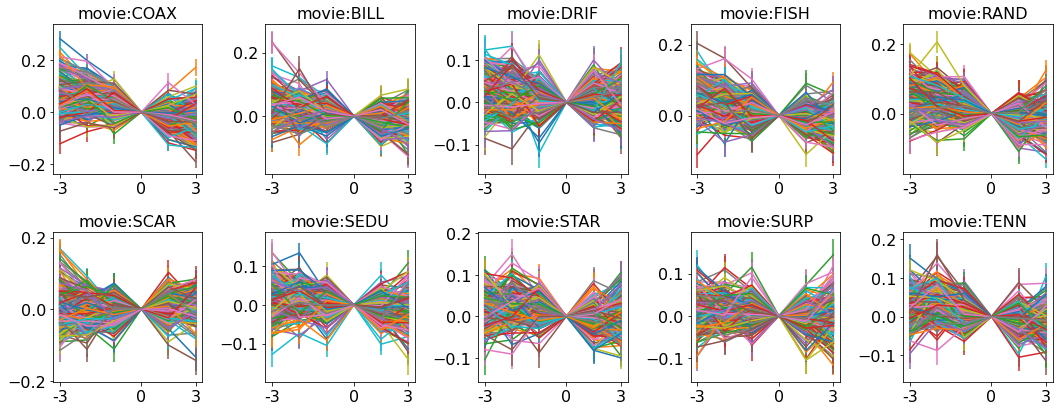

In [30]:
# to see if there are any trends in the 1st 3 TRs in the runwise norm

Y = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm.npy'))
plt.figure(1,figsize =(15,6))
for m in range(10):
    r = 'run1' if m<5 else 'run2'
    plt.subplot(2,5,m+1)
    for n in np.arange(0,268):
        plt.errorbar(range(6), np.nanmedian(Y[:,n,:tr0_ind+3,m],axis=0),stats.sem(Y[:,n,:tr0_ind+3,m],axis=0,
                                                                                  nan_policy='omit'))
        plt.title(f'movie:{str.upper(vid_names[r][m%5][:4])}')
        plt.xticks([0,3,5],[-3,0,3])

#plt.errorbar(range(6), np.nanmean(Y[:,:10,:tr0_ind+3,0],axis=(0,1)),
#             np.nanstd(Y[:,:10,:tr0_ind+3,0],axis=(0,1)))
plt.tight_layout()


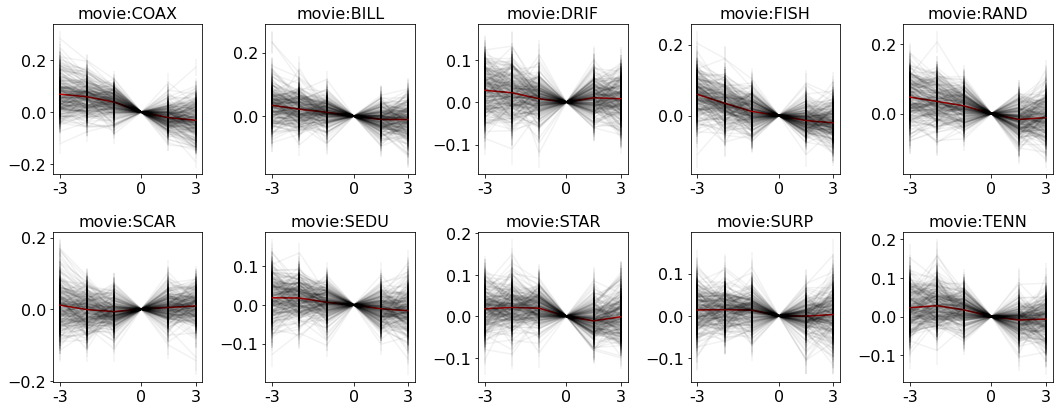

In [39]:
# to see if there are any trends in the 1st 3 TRs in the runwise norm

Y = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm.npy'))
plt.figure(1,figsize =(15,6))
for m in range(10):
    r = 'run1' if m<5 else 'run2'
    plt.subplot(2,5,m+1)
    for n in np.arange(0,268):
        plt.errorbar(range(6), np.nanmedian(Y[:,n,:tr0_ind+3,m],axis=0),
                     stats.sem(Y[:,n,:tr0_ind+3,m],axis=0, nan_policy='omit'),color ='k', alpha = .05)
        plt.title(f'movie:{str.upper(vid_names[r][m%5][:4])}')
        plt.xticks([0,3,5],[-3,0,3])
    plt.plot(range(6), np.nanmedian(Y[:,:,:tr0_ind+3,m],axis=(0,1)), color = 'r', alpha = 1)
        
#plt.errorbar(range(6), np.nanmean(Y[:,:10,:tr0_ind+3,0],axis=(0,1)),
#             np.nanstd(Y[:,:10,:tr0_ind+3,0],axis=(0,1)))
plt.tight_layout()



In [32]:
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape

(1048, 10)

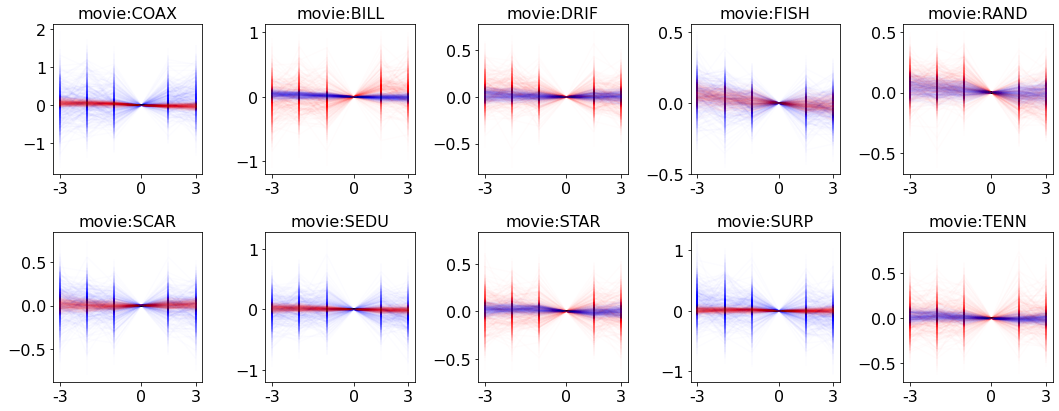

In [47]:
# to see if there are any trends in the 1st 3 TRs in the runwise norm

Y = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm.npy'))
plt.figure(1,figsize =(15,6))
for m in range(10):
    r = 'run1' if m<5 else 'run2'
    plt.subplot(2,5,m+1)
    subs1 = responses[:,m] == 1
    subs2 = responses[:,m] == 0
    for n in np.arange(0,268):
        plt.errorbar(range(6), np.nanmedian(Y[subs1,n,:tr0_ind+3,m],axis=0),
                     stats.sem(Y[subs1,n,:tr0_ind+3,m],axis=0,nan_policy='omit'),color = 'r',alpha = .01)
        
        
        plt.errorbar(range(6), np.nanmedian(Y[subs2,n,:tr0_ind+3,m],axis=0),
                     stats.sem(Y[subs2,n,:tr0_ind+3,m],axis=0,  nan_policy='omit'),color = 'b', alpha = .01)
        
        
    #plt.plot(range(6), np.nanmedian(Y[subs1,:,:tr0_ind+3,m],axis=(0,1)),color = 'r',alpha = 1,
    #         marker = 'o',ls = 'dotted')
    #plt.plot(range(6), np.nanmedian(Y[subs2,:,:tr0_ind+3,m],axis=(0,1)),color = 'b',alpha = 1,
    #         marker = 'o',ls = 'dotted')
    plt.title(f'movie:{str.upper(vid_names[r][m%5][:4])}')
    plt.xticks([0,3,5],[-3,0,3])
    
#plt.errorbar(range(6), np.nanmean(Y[:,:10,:tr0_ind+3,0],axis=(0,1)),
#             np.nanstd(Y[:,:10,:tr0_ind+3,0],axis=(0,1)))
plt.tight_layout()



In [68]:
range(y.shape[2])


range(0, 32)

In [69]:
[np.ndarray.flatten(y[subs1,:,i] for i in range(4))]


TypeError: descriptor 'flatten' for 'numpy.ndarray' objects doesn't apply to a 'generator' object

In [71]:
y = Y[:,:,:,m]
grp1 = np.array([np.ndarray.flatten(y[subs1,:,i]) for i in range(6)]).T
grp1.shape

(12596, 6)

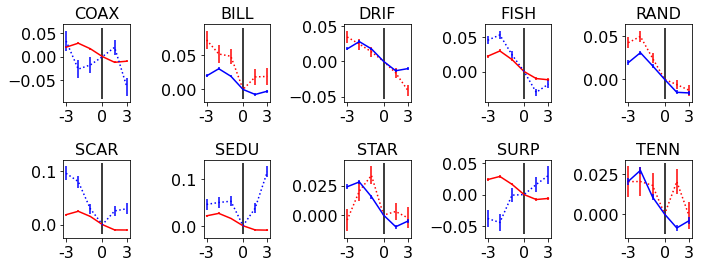

In [73]:
# to see if there are any trends in the 1st 3 TRs in the runwise norm
vid_type = [1,0,0,1,0,1,1,0,1,0]
linest_r = ['dotted','solid']
linest_b = ['solid','dotted']
Y = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm.npy'))
plt.figure(1,figsize =(10,4))
for m in range(10):
    r = 'run1' if m<5 else 'run2'
    plt.subplot(2,5,m+1)
    subs1 = responses[:,m] == 1
    subs2 = responses[:,m] == 0
    grp1 = np.array([np.ndarray.flatten(y[subs1,:,i]) for i in range(6)]).T
    grp2 = np.array([np.ndarray.flatten(y[subs2,:,i]) for i in range(6)]).T
    
    plt.errorbar(range(6), np.nanmedian(grp1,axis=0),stats.sem(grp1,axis=0),color = 'r',alpha = 1,
             ls = linest_r[vid_type[m]])
    plt.errorbar(range(6), np.nanmedian(grp2,axis=0),stats.sem(grp2,axis=0), color = 'b',alpha = 1,
             ls = linest_b[vid_type[m]])
    plt.title(str.upper(vid_names[r][m%5][:4]))
    plt.xticks([0,3,5],[-3,0,3])
    ymin,ymax = plt.ylim()
    plt.vlines(3,ymin,ymax,color = 'k')
    
#plt.errorbar(range(6), np.nanmean(Y[:,:10,:tr0_ind+3,0],axis=(0,1)),
#             np.nanstd(Y[:,:10,:tr0_ind+3,0],axis=(0,1)))
plt.tight_layout()




In [28]:
vid_names

{'run1': ['COAXING-B',
  'BILLIARD-A',
  'DRIFTING-A',
  'Fishing',
  'Random mechanical'],
 'run2': ['Scaring', 'SEDUCING-B', 'STAR-A', 'SURPRISING-B', 'TENNIS-A']}

subj: 0 , time elapsed: 0.0 mins
subj: 50 , time elapsed: 0.07 mins
subj: 100 , time elapsed: 0.15 mins
subj: 150 , time elapsed: 0.22 mins
subj: 200 , time elapsed: 0.29 mins
subj: 250 , time elapsed: 0.36 mins
subj: 300 , time elapsed: 0.45 mins
subj: 350 , time elapsed: 0.53 mins
subj: 400 , time elapsed: 0.6 mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj: 450 , time elapsed: 0.67 mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj: 500 , time elapsed: 0.74 mins
subj: 550 , time elapsed: 0.82 mins
subj: 600 , time elapsed: 0.91 mins
subj: 650 , time elapsed: 1.0 mins
subj: 700 , time elapsed: 1.07 mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj: 750 , time elapsed: 1.14 mins
subj: 800 , time elapsed: 1.22 mins
subj: 850 , time elapsed: 1.29 mins
subj: 900 , time elapsed: 1.38 mins
subj: 950 , time elapsed: 1.46 mins
subj: 1000 , time elapsed: 1.53 mins
subj: 1050 , time

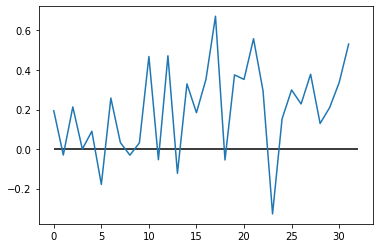

In [276]:
# TRIAL-WISE: subjectwise normalisation(maxmin) within a TRIAL, and then baseline correction wrt t=0 
# (i.e., TR=3).
# including the extra 14s post stim as was done till May 2021 - trying to to replicate earlier results

start = time.time()

#y0 = np.zeros((nsubj,nmovies,nnodes))
Ynorm = np.zeros((nsubj, nnodes, ntimepts,nmovies))

sub_ind = -1
for s1 in np.arange(0,nsubj):
    now = time.time()
    if s1 % 50 == 0: # print status updates occasionally
        print('subj:',s1,', time elapsed:', np.round((now - start)/60,2),'mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. 126628
    try:
        s2 = subj_list['run2'].index(curr_subj) 
        # see if the subject has data for run 2, if not don't count them

        # proceed if sub has data for both runs
        curr_subj = int(curr_subj)
        sub_ind += 1 # for each sub with run1 and 2

        # step 1: normalization
        for node in range(nnodes):
            for vid_no in np.arange(0,nmovies):
                run = 'run1' if vid_no < 5 else 'run2'
                size = timepts_indiv_movie[vid_no].shape[0]
                image_TRs = np.empty((size+14,))
                image_TRs[:size] = timepts_indiv_movie[vid_no] # rows within run for that video
                image_TRs[size:] = np.arange(timepts_indiv_movie[vid_no][-1],
                                             timepts_indiv_movie[vid_no][-1]+14)
                image_TRs = np.array([int(i) for i in image_TRs])
                Y =  dat[run][s1,image_TRs,node] # 274 timepts

                #Y = stats.zscore(Y) # within trial Z-score norm
            
                Y -= np.min(Y[tr0_ind:]) # within trial maxmin norm
                Y = np.divide(Y,np.max(Y[tr0_ind:])) # all values within 0-1
            
                Y = Y - Y[tr0_ind] # baseline correction wrt t=0 (index 3 or tr0_ind), saved as time..movies
                #Y = Y-np.nanmean(Y[:tr0_ind])  # saved as time...movies2
                Y = Y[:size]
                Ynorm[sub_ind,node,:,vid_no] = Y # assign to 4D array
                if (vid_no == 0) and (sub_ind == 0) and (node==0):
                    plt.plot(Ynorm[sub_ind,node,:,vid_no])
                    plt.hlines(0,0,32,color = 'k')
                
    except:
            print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:]
now = time.time()
if nsubj == 1053:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_maxminnorm_extra14TRs'), Ynorm)
    #np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies2'), Ynorm)

print('\n\nData saved on/at:',datetime.now())


In [43]:
tc_trialwise = np.load(os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies.npy'))
tc_trialwise.shape

(1049, 268, 32, 10)

[ 1.02307129  0.9796905   1.09068966  0.         -0.12491478 -0.30056714
 -0.5853078  -0.95568673 -1.06147999 -0.89623886 -1.46975513 -1.42367736
 -1.70527114 -2.34432465 -2.13890158 -2.15658883 -1.73237809 -1.29058581
 -0.68610972 -0.20367141 -0.0807425   0.51878839  0.93470657  0.71238737
  1.32008467  0.97344562  0.10958943 -0.35538365 -0.51157397 -0.4692046
 -1.41502307 -0.7402681 ]
[ 0.99276378  0.9506681   1.05837902  0.         -0.1212143  -0.29166313
 -0.56796861 -0.92737542 -1.03003466 -0.86968864 -1.42621503 -1.38150228
 -1.65475411 -2.27487627 -2.07553866 -2.09270195 -1.68105804 -1.25235343
 -0.66578437 -0.19763784 -0.07835058  0.50341978  0.90701678  0.69128358
  1.28097842  0.94460823  0.10634294 -0.34485574 -0.49641908 -0.45530486
 -1.37310436 -0.71833837]
[ 0.86957593  0.83270372  0.92704925  0.         -0.10617333 -0.25547189
 -0.49749179 -0.81230133 -0.90222202 -0.76177266 -1.24924205 -1.21007751
 -1.44942268 -1.9925965  -1.81799386 -1.83302742 -1.47246267 -1.0969542
 

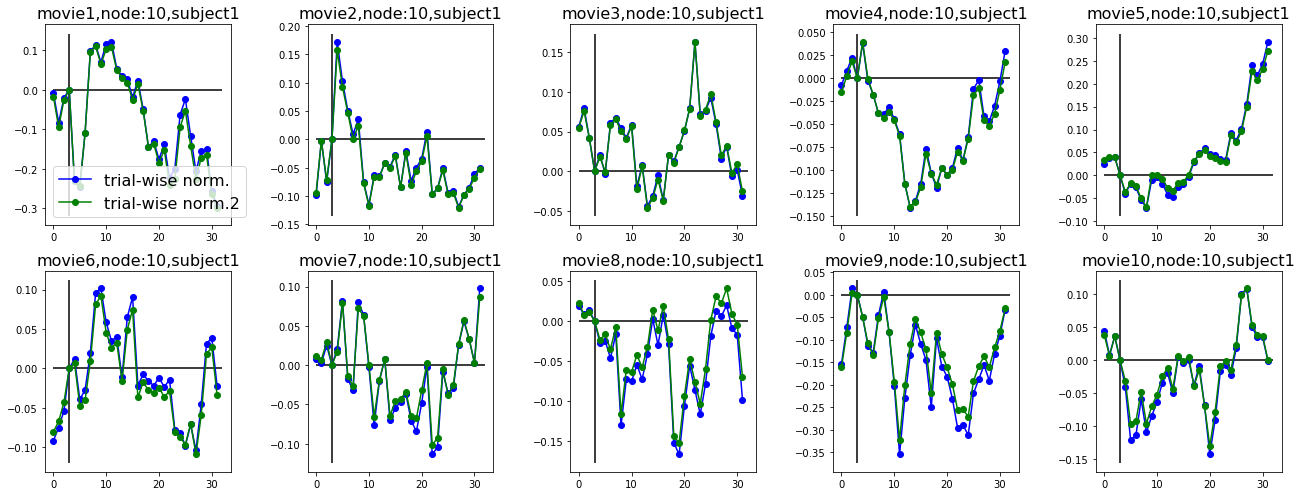

In [43]:
plt.figure(1,figsize = (18,7))
n = 10
s = 1
tc_trialwise = np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies.npy'))
tc_trialwise2 = np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_normwrtextra14TRs.npy'))
tc_runwise = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies.npy'))
print(tc_runwise[s,n,:,0])
print(tc_trialwise[s,n,:,0])
print(tc_trialwise2[s,n,:,0])
ax = (0,1)
for m in range(10):
    plt.subplot(2,5,m+1)
    plt.title(f'movie{str(m+1)},node:{n},subject{s}',fontsize = 16)
    
    #plt.plot(np.nanmean(tc_runwise[responses[:,m]==1,:,:,m],axis=ax)-
    #np.nanmean(tc_runwise[responses[:,m]==0,:,:,m],axis=ax),
    #label = 'run-wise norm.', color = 'r',marker = 'o')
    plt.plot(np.nanmean(tc_trialwise[responses[:,m]==1,:,:,m],axis=ax)-
             np.nanmean(tc_trialwise[responses[:,m]==0,:,:,m],axis=ax),
             label = 'trial-wise norm.',color = 'b',marker = 'o')
    plt.plot(np.nanmean(tc_trialwise2[responses[:,m]==1,:,:,m],axis=ax)-
             np.nanmean(tc_trialwise2[responses[:,m]==0,:,:,m],axis=ax),
             label = 'trial-wise norm.2', color = 'g',marker = 'o')
    if m ==0:
        plt.legend(fontsize = 16)
    plt.hlines(0,0,32,color = 'k')
    ymin,ymax = plt.ylim()
    plt.vlines(tr0_ind,ymin,ymax,color = 'k')
plt.tight_layout()

- As can be seen from the figure above, overall, baseline correction wrt to the t-3:t timepts' mean is better to centre data, however, this can give rise to diffs at t=0 which is hard to interpret
- so makes more sense to baseline correct wrt t=0 and then lok at systematic diffs between groups from t-3 to t to better understand what is going on


In [74]:
tc = np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-movie{m}.npy'))

tc.shape

(1049, 268, 43)

Finished video 0 , elapsed time: 0.18593406677246094
Finished video 1 , elapsed time: 0.3631250858306885
Finished video 2 , elapsed time: 0.5232131481170654
Finished video 3 , elapsed time: 0.6842670440673828
Finished video 4 , elapsed time: 0.8702201843261719
Finished video 5 , elapsed time: 1.0409998893737793
Finished video 6 , elapsed time: 1.2004759311676025
Finished video 7 , elapsed time: 1.4011650085449219
Finished video 8 , elapsed time: 1.5922482013702393
Finished video 9 , elapsed time: 1.7549829483032227


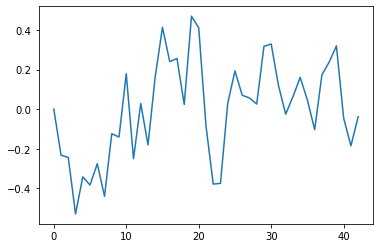

In [19]:
# takes 30mins to run, watch out!
# preprocess Y, store (1) moviewise timecourses, (2) baseline normY and beh responses across movies
# save preprocessed timecourses for each movie in 10 files (each file about 96MB)
nsubj = 1 #1053
nmovies = 10#10
nnodes = 268 #268
start = time.time()

y0 = np.zeros((nsubj,nmovies,nnodes))
responses = np.zeros((nsubj,nmovies))-1 # initialise responses with -1
    
for vid_no in np.arange(0,nmovies):
    run = 'run1' if vid_no < 5 else 'run2'
    vidName = vid_names[run][vid_no%5]
    vidName = '.'.join((vidName,'AVI')) # add .avi
         
    ntimepts  = len(timepts_indiv_movie[vid_no])
    Ynorm = np.zeros((nsubj, nnodes, ntimepts))

    sub_ind = -1
    for s1 in np.arange(0,nsubj):
        now = time.time()
        #print('subj:',s1,', time elapsed:', (now - start))
        curr_subj = subj_list['run1'][s1]
        try:
            s2 = subj_list['run2'].index(curr_subj) 
                # see if the subject has data for run 2, if not don't count them
            
            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
            if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                responses[sub_ind,vid_no] = beh_data.loc[row,'response']

            for node in range(nnodes):
                rows = timepts_indiv_movie[vid_no] # rows within run for that video
                if run == 'run1':
                    Y = dat[run][s1,rows,node] 
                elif run == 'run2':
                    Y = dat[run][s2,rows,node]
                
                Ynorm[sub_ind,node,:],y0[sub_ind,vid_no,node] = preproc(Y) # baseline correction and normalisation
                if (vid_no == 0) and (s1 == 0) and (node==0):
                    plt.plot(Ynorm[sub_ind,node,:])
        except:
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

    Ynorm = Ynorm[:sub_ind+1,:,:]
    now = time.time()
    np.save(f'timecourse-movie{vid_no}', Ynorm)
    print('Finished video', vid_no, ', elapsed time:', now-start)

responses = responses[:sub_ind+1,:]
y0 = responses[:sub_ind+1,:]


['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Finished video 0 , elapsed time: 153.57377934455872
['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Finished video 1 , elapsed time: 311.26968717575073
['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Finished video 2 , elapsed time: 788.555064201355
['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710,

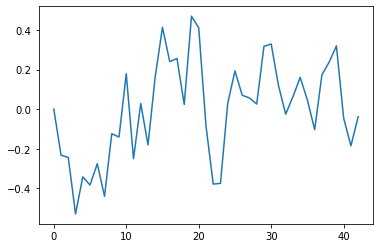

In [78]:
# takes 30mins to run, watch out!
# preprocess Y, store (1) moviewise timecourses, (2) baseline normY and beh responses across movies
# save preprocessed timecourses for each movie in 10 files (each file about 96MB)
nsubj = 1053 #1053
nmovies = 10#10
nnodes = 268 #268
start = time.time()

y0 = np.zeros((nsubj,nmovies,nnodes))
responses = np.zeros((nsubj,nmovies))-1 # initialise responses with -1
    
for vid_no in np.arange(0,nmovies):
    run = 'run1' if vid_no < 5 else 'run2'
    vidName = vid_names[run][vid_no%5]
    vidName = '.'.join((vidName,'AVI')) # add .avi
         
    ntimepts  = len(timepts_indiv_movie[vid_no])
    Ynorm = np.zeros((nsubj, nnodes, ntimepts))

    sub_ind = -1
    for s1 in np.arange(0,nsubj):
        now = time.time()
        #print('subj:',s1,', time elapsed:', (now - start))
        curr_subj = subj_list['run1'][s1]
        try:
            s2 = subj_list['run2'].index(curr_subj) 
                # see if the subject has data for run 2, if not don't count them
            
            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
            if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                responses[sub_ind,vid_no] = beh_data.loc[row,'response']

            for node in range(nnodes):
                rows = timepts_indiv_movie[vid_no] # rows within run for that video
                if run == 'run1':
                    Y = dat[run][s1,rows,node] 
                elif run == 'run2':
                    Y = dat[run][s2,rows,node]
                
                Ynorm[sub_ind,node,:],y0[sub_ind,vid_no,node] = preproc(Y) # baseline correction and normalisation
                if (vid_no == 0) and (s1 == 0) and (node==0):
                    plt.plot(Ynorm[sub_ind,node,:])
        except:
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

    Ynorm = Ynorm[:sub_ind+1,:,:]
    now = time.time()
    np.save(f'timecourse-movie{vid_no}', Ynorm)
    print('Finished video', vid_no, ', elapsed time:', now-start)

responses = responses[:sub_ind+1,:]
y0 = responses[:sub_ind+1,:]
np.save('beh_responses', responses)
np.save('ybsln_slopereg', y0)

In [79]:
1919/60

31.983333333333334

### Extra code

In [36]:
def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window

    Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window

    There are smarter and faster solutions (e.g. using convolution) but this
    function shows what the output really means. This function skips NaNs, and
    should not be susceptible to edge effects: it will simply use
    all the  available samples, which means that close to the edges of the
    signal or close to NaNs, the output will just be based on fewer samples. By
    default, this function will apply a mean to the samples in the window, but
    this can be changed to be a max/min/median or other function that returns a
    single numeric value based on a sequence of values.
    """

    # if data is a matrix, apply filter to each row:
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],
                                             window=window,
                                             FUN=FUN)
        return output

    # make output array of the same size as x:
    output = np.zeros(x.size)

    # loop through the signal in x
    for samp_i in range(x.size):

        values = []

        # loop through the window:
        for wind_i in range(int(1 - window), 1):

            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue

            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]

        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)

    return output

In [ ]:
def preproc(Y):
    # function to normalise timecourses and baseline correct them
    #Y = my_moving_window(Y)
    Y = Y - np.min(Y)
    Y = Y/np.max(Y)
    Y = Y - Y[0]
    return Y,Y[0]

## Creating the regressor, adding haemodynamic delay to on/offset TRs

In [ ]:
#defining the hrf
from nltools.external import glover_hrf

#hrf function
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

In [ ]:
# Here we (1) create movie_wise SLOPE regressors and (2) response regressors.
# only for regressor analysis. change slope to block as needed. This cell isn't too important for current analyses


reg_all = [] # slope regressor per movie
reg_conv_all = [] # to store slope regressors for all movies
respreg_all = [] # to store response regressors for all movies
respreg_conv_all = [] # response window in block per movie

for vid_no in range(nmovies):
    run = "run1" if vid_no < 5 else "run2"
    vrun = vid_no%5
    vid = vid_names[run][vrun]
    #print(vid)
    
    start_frame = int(vid_onsets_imagenr[vrun]) - l_fix_start # change l_fix_start to start the 
                                                   # regressor earlier
    end_frame = int(vid_onsets_imagenr[vrun]) + l_task + l_fix_end  # onset frame + length of video +
                                                         # (response screen+fixation time)
    vid_start = int(vid_onsets_imagenr[vrun]) 
    vid_start = vid_start - start_frame # 0 if same pt, >0 otherwise
    #print('vid_start',vid_start)
    vid_end = vid_start + l_task 
    #print('vid_end',vid_end)
    reg = np.zeros((end_frame+1-start_frame))
    reg[vid_start:vid_end+1] = np.arange(0,l_task+1)/np.max(np.arange(0,l_task+1))
            # normalised ascending slope regressor 
            # + 1 (to include last timept too)

    reg_conv = np.convolve(reg, hrf) # convolve reg with HRF
    reg_conv = reg_conv[:len(reg)] # make convolved regressor same length as original regressor
    
    if vid_no == 0:
        plt.figure(figsize = (6,4))
        plt.plot(reg,      label = 'slope reg.', color = 'k')
        plt.plot(reg_conv, label = 'reg. conv.', color = 'k', ls = 'dashed')
        plt.xlabel('Image #', fontsize = 16)
        plt.yticks([0,1],['',''], fontsize = 16)
    reg_all.append(reg)
    reg_conv_all.append(reg_conv) # slope regressors for each movie
    
    # part 2
    resp_screen_start = vid_end # get the relevant frames by converting sec to tr
    resp_screen_end = resp_screen_start + RW_secs
    respreg = np.zeros((end_frame+1-start_frame))
    respreg[resp_screen_start:resp_screen_end+1] = 1
    respreg_conv = np.convolve(respreg, hrf)
    respreg_conv = respreg_conv[:len(respreg)]
    if vid_no == 0:
        plt.plot(respreg, label = 'resp reg.', color = 'gray')
        plt.plot(respreg_conv,    label = 'resp reg. conv.', color = 'grey', ls = 'dashed')
        plt.legend(loc = 'best', fontsize = 16)
        plt.xticks(np.arange(0,31),)
        #plt.xlabel('Image #', fontsize = 16)
        #plt.yticks([0,1],['',''], fontsize = 16)
    respreg_all.append(respreg)
    respreg_conv_all.append(respreg_conv) # block response regressors for each movie




In [ ]:
#save regressor variables

import pickle
os.chdir(data_file_loc)
pickle.dump([reg_all, reg_conv_all, respreg_all, respreg_conv_all],
            open("movie_wise_regs_windows.p", "wb")) # saving regressor variables

reg_all, reg_conv_all, respreg_all, respreg_conv_all = \
            pickle.load(open("movie_wise_regs_windows.p","rb")) # to verify the saved variables

## Max-min normalization

In [ ]:
# RUN-wise normalisation (max min) and then baseline correction wrt the means of t = -3 to -1.

# seeing tif maxmin norm is better

# preprocess Y, store (1) moviewise timecourses, (2) baseline normY and beh responses across movies
# save preprocessed timecourses for each movie in a single file
start = time.time()

#y0 = np.zeros((nsubj,nmovies,nnodes))
#responses = np.empty((nsubj, nmovies))
#responses[:] = np.nan # initialise responses with NaN
sub_id_all = []
Ynorm = np.zeros((nsubj, nnodes, ntimepts, nmovies))
plot_fig = 1
if plot_fig:
    plt.figure(1,figsize=(10,8))
sub_ind = -1
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print('subj:',s1,', time elapsed:', np.round((now - start)/60,2),'mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620':
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                #vidName = vid_names[run][vid_no%5]
                #vidName = '.'.join((vidName,'AVI')) # add .avi

                #row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                #    responses[sub_ind,vid_no] = beh_data.loc[row,'response']
                #if len(np.where(row)[0]) > 1:
                #    print('error!!!!')

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,:,node] # 274 TRs/run
                tc_run2 = dat['run2'][s2,:,node] 

                #tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
                #tc_run2 = stats.zscore(tc_run2)
                
                ## YET TO ADD DETRENDING##

                tc_run1 -= min(tc_run1[5:]) # alternate option: to use max-min normalization
                tc_run1 = np.divide(tc_run1,np.max(tc_run1[5:])) # all values within 0-1
                tc_run2 -= min(tc_run2[5:])
                tc_run2 = np.divide(tc_run2,np.max(tc_run2[5:])) # all values within 0-1
                # why not just exclude the first 5 points? because this way
                # can retain the same indices, ut data unaffected by initial random 
                # values which may skew the normalized values
                
                if sub_ind < 100:
                    all_runs_maxmin[sub_ind,node,:,0] = tc_run1
                    all_runs_maxmin[sub_ind,node,:,1] = tc_run2

                # baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 

                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    if plot_fig:
                        if node == 0:
                            if (vid_no in [0,5]) and (sub_ind == 0) and (node==0):
                                #print(np.nanmean(Y[0:2]))
                                #print(Y)
                                plt.subplot(2,1,1)
                                plt.plot(tc_run1 if run == 'run1' else tc_run2) # plot a run for a single subject
                            #plt.subplot(2,5,vid_no+1)
                            #plt.plot(Y, marker ='o')

                    #Y = Y-np.nanmean(Y[0:tr0_ind]) #baseline correct using the mean of the 3 TRs prior to stimulus onset
                    Y = Y-Y[tr0_ind] #baseline correct using the mean of the 3 TRs prior to stimulus onset
                    Ynorm[sub_ind,node,:,vid_no] = Y # assign to a 4D array
                    if (vid_no == 0) and (sub_ind == 0) and (node==0): # plot the first tc to illustrate
                        plt.subplot(2,2,3)
                        plt.plot(Ynorm[sub_ind,node,:,vid_no])
                        runs_to_plot.append(tc_run1)

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows
#responses = responses[:sub_ind+1,:]

if plot_fig:
    plt.tight_layout()
    
if nsubj == 1053:
    np.save(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_maxminnorm'), Ynorm) # save timecourses
    #np.save(os.path.join(data_file_loc,'responses.npy'), responses) # save beh responses

print('\n\nData saved on/at:',datetime.now()) # cell run at



In [ ]:
# TRIAL-WISE: subjectwise normalisation(maxmin) within a TRIAL, and then baseline correction wrt t=0 
# (i.e., relative TR=3).

# to see if maxmin norm is better

start = time.time()

#y0 = np.zeros((nsubj,nmovies,nnodes))
Ynorm = np.zeros((nsubj, nnodes, ntimepts,nmovies))

sub_ind = -1
for s1 in np.arange(0,nsubj):
    now = time.time()
    if s1 % 50 == 0: # print status updates occasionally
        print('subj:',s1,', time elapsed:', np.round((now - start)/60,2),'mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. 126628
    if curr_subj != '105620':
        try:
            s2 = subj_list['run2'].index(curr_subj) 
            # see if the subject has data for run 2, if not don't count them

            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            # step 1: normalization
            for node in range(nnodes):

                for vid_no in np.arange(0,nmovies):
                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # rows within run for that video

                    Y =  dat[run][s1,image_TRs,node] # 274 timepts
                    
                    ## YET TO ADD DETRENDING##

                    Y -= np.min(Y[tr0_ind:]) # within trial maxmin norm
                    Y = np.divide(Y,np.max(Y[tr0_ind:])) # all values within 0-1

                    #Y = stats.zscore(Y) # within trial Z-score norm

                    Y = Y - Y[tr0_ind] # baseline correction wrt t=0 (index 3 or tr0_ind), saved as time..movies
                    #Y = Y-np.nanmean(Y[:tr0_ind])  # saved as time...movies2
                    Ynorm[sub_ind,node,:,vid_no] = Y # assign to 4D array
                    if (vid_no == 0) and (sub_ind == 0) and (node==0):
                        plt.plot(Ynorm[sub_ind,node,:,vid_no])
                        plt.hlines(0,0,32,color = 'k')
                
        except:
            print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:]
now = time.time()
if nsubj == 1053:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_maxminnorm'), Ynorm)
    #np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies2'), Ynorm)

print('\n\nData saved on/at:',datetime.now())



In [ ]:
# figure for one-on-one meeting on 17.08.21
x = np.zeros((181,))
for i in range(len(vid_onsets_in_sec)):
    x[vid_onsets_in_sec[i]:vid_onsets_in_sec[i]+20] = 1
    
for i in range(2):
    plt.figure(i,figsize = (30,5))
    #plt.plot(x,marker = 'o', label = 'video block (secs)')
    x_ims = [tr*i for i in range(int(np.ceil(181/tr)))]
    x_ims
    #for i in vid_onsets_imagenr:
    #    plt.vlines(x_ims[i-5:i+5],-1,1)
    
    if i==0:
        plt.plot(runs_to_plot[0],label = 'zscore')
    else:
        plt.plot(runs_to_plot[1],label = 'max-min norm')
    ymin,ymax = plt.ylim()
    plt.vlines(vid_onsets_imagenr,ymin,ymax,color = 'r', label = 'onset TR (prev)')
    plt.vlines((vid_onsets_imagenr+28),ymin,ymax,color = 'r', ls = 'dashed',label = 'offset TR (prev)')
    plt.vlines((vid_onsets_imagenr),ymin,ymax,color = 'magenta', label = 'onset TR0')
    plt.vlines((vid_onsets_imagenr+28),ymin,ymax,color = 'magenta', ls = 'dashed', label = 'offset TR28')
    
    plt.xticks(fontsize =20)
    plt.yticks([0,1],fontsize =20)
    #for ind in range(len(x_ims[:100])):
    #    plt.text(x_ims[ind],5,ind,rotation=90,fontsize = 20)
    #plt.ylim(-.2,2)
    #plt.xlim(0,75)
    plt.xlabel('Time in secs',fontsize =20)
    plt.ylabel('Video = 1, Rest =0',fontsize =20)
    plt.legend(fontsize =20, bbox_to_anchor=(0.25, -.1))